第 0 此迭代，成本值为: 0.715731513413713
第 100 此迭代，成本值为: 0.6747377593469114
第 200 此迭代，成本值为: 0.6603365433622127
第 300 此迭代，成本值为: 0.6462887802148751
第 400 此迭代，成本值为: 0.6298131216927773
第 500 此迭代，成本值为: 0.606005622926534
第 600 此迭代，成本值为: 0.5690041263975134
第 700 此迭代，成本值为: 0.519796535043806
第 800 此迭代，成本值为: 0.46415716786282285
第 900 此迭代，成本值为: 0.40842030048298916
第 1000 此迭代，成本值为: 0.37315499216069026
第 1100 此迭代，成本值为: 0.30572374573047106
第 1200 此迭代，成本值为: 0.26810152847740837
第 1300 此迭代，成本值为: 0.23872474827672654
第 1400 此迭代，成本值为: 0.20632263257914718
第 1500 此迭代，成本值为: 0.17943886927493605
第 1600 此迭代，成本值为: 0.1579873581880163
第 1700 此迭代，成本值为: 0.14240413012274492
第 1800 此迭代，成本值为: 0.12865165997888675
第 1900 此迭代，成本值为: 0.1124431499816437
第 2000 此迭代，成本值为: 0.08505631034982422
第 2100 此迭代，成本值为: 0.05758391198616691
第 2200 此迭代，成本值为: 0.044567534546991264
第 2300 此迭代，成本值为: 0.03808275166600256
第 2400 此迭代，成本值为: 0.034410749018419895


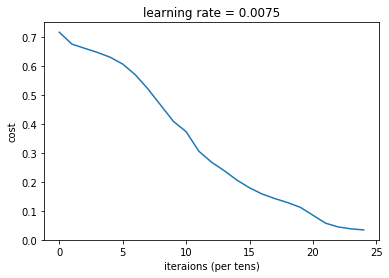

准确度为: 0.9952153110047847
准确度为: 0.78


In [3]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import testCases
from dnn_utils import sigmoid , sigmoid_backward , relu , relu_backward
import lr_utils

np.random.seed(1)

def initialize_parameters(n_x,n_h,n_y):
    W1 = np.random.randn(n_h , n_x) * 0.01
    b1 = np.zeros((n_h,1))
    W2 = np.random.randn(n_y , n_h) * 0.01
    b2 = np.zeros((n_y,1))
    
    parameters = {
        "W1" : W1,
        "b1" : b1,
        "W2" : W2,
        "b2" : b2
    }
    
    return parameters

def initialize_parameters_deep(layers_dims):
    np.random.seed(3)
    parameters = {}
    L = len(layers_dims)
    for l in range(1,L) :
        parameters["W"+str(l)] = np.random.randn(layers_dims[l] , layers_dims[l - 1]) / np.sqrt(layers_dims[l - 1])
        parameters["b"+str(l)] = np.zeros((layers_dims[l] , 1))
        
    return parameters

def linear_forward(A , W , b ):
    Z = np.dot(W,A) + b
    cache = (A,W,b)
    return Z,cache

def linear_activation_forward(A_prev , W , b ,activation):
    if activation == "sigmoid":
        Z , linear_cache = linear_forward(A_prev , W ,b)
        A , activation_cache = sigmoid(Z)
    elif activation == "relu":
        Z , linear_cache = linear_forward(A_prev , W ,b)
        A , activation_cache = relu(Z)
    cache = (linear_cache , activation_cache)
    return A , cache

def L_model_forward(X,parameters):
    caches = []
    A = X
    L = len(parameters) // 2
    for l in range(1,L):   #range是不包括Stop位置处的
        A_prev = A
        A , cache = linear_activation_forward(A_prev,parameters["W"+str(l)],parameters["b"+str(l)],"relu")
        caches.append(cache)
    AL ,cache = linear_activation_forward(A ,parameters["W"+str(L)],parameters["b"+str(L)],"sigmoid")
    caches.append(cache)
    
    return AL , caches

def compute_cost(AL , Y):
    m = Y.shape[1]
    cost = -np.sum(np.multiply(np.log(AL),Y) + np.multiply(np.log(1 - AL),(1-Y))) / m
    cost = np.squeeze(cost)
    
    return cost

def linear_backward(dZ,cache):
    A_prev , W , b = cache
    m = A_prev.shape[1]
    dW = np.dot(dZ , A_prev.T) / m
    db = np.sum(dZ, axis=1, keepdims=True) / m
    dA_prev = np.dot(W.T,dZ)
    
    return dA_prev , dW ,db

def linear_activation_backward(dA , cache ,activation="relu"):
    linear_cache , activation_cache = cache
    if activation == "relu":
        dZ = relu_backward(dA , activation_cache)
        dA_prev , dW , db = linear_backward(dZ , linear_cache)
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA , activation_cache)
        dA_prev , dW , db = linear_backward(dZ , linear_cache)
    
    return dA_prev , dW , db

def L_model_backward(AL , Y , caches):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    dAL = - (np.divide(Y , AL) - np.divide(1 - Y , 1 - AL))
    
    current_cache = caches[L-1]
    grads["dA"+str(L)],grads["dW"+str(L)],grads["db"+str(L)] = linear_activation_backward(dAL,current_cache,"sigmoid")
    
    for l in reversed(range(0,L-1)):
        current_cache = caches[l]
        dA_prev_tmp,dW_tmp,db_tmp = linear_activation_backward(grads["dA"+str(l+2)] , current_cache,"relu")
        grads["dA"+str(l+1)] = dA_prev_tmp
        grads["dW"+str(l+1)] = dW_tmp
        grads["db"+str(l+1)] = db_tmp
        
    return grads

def update_parameters(parameters,grads,learning_rate):
    L = len(parameters) // 2
    for l in range(L):
        parameters["W"+str(l+1)] = parameters["W"+str(l+1)] - learning_rate * grads["dW"+str(l+1)]
        parameters["b"+str(l+1)] = parameters["b"+str(l+1)] - learning_rate * grads["db"+str(l+1)]
    
    return parameters

def two_layer_model(X,Y,layers_dims,learning_rate=0.0075,num_iterations = 3000 , print_cost = False, isPlot = True):
    np.random.seed(1)
    grads = {}
    costs = []
    (n_x,n_h,n_y) = layers_dims
    
    parameters = initialize_parameters(n_x,n_h,n_y)
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    for l in range(0,num_iterations):
        A1 , cache1 = linear_activation_forward(X,W1,b1,"relu")
        A2 , cache2 = linear_activation_forward(A1,W2,b2,"sigmoid")
        
        cost = compute_cost(A2 , Y)
        
        dA2 = -(np.divide(Y,A2) - np.divide(1-Y,1-A2))
        
        dA1 , dW2 , db2 = linear_activation_backward(dA2,cache2,"sigmoid")
        dA0 , dW1 , db1 = linear_activation_backward(dA1,cache1,"relu")
        
        grads["dW1"] = dW1
        grads["db1"] = db1
        grads["dW2"] = dW2
        grads["db2"] = db2

        #更新参数
        parameters = update_parameters(parameters,grads,learning_rate)
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]

        #打印成本值，如果print_cost=False则忽略
        if l % 100 == 0:
            #记录成本
            costs.append(cost)
            #是否打印成本值
            if print_cost:
                print("第", l ,"次迭代，成本值为：" ,np.squeeze(cost))
    #迭代完成，根据条件绘制图
    if isPlot:
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

    #返回parameters
    return parameters


#两层训练
#parameters = two_layer_model(train_x, train_set_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True,isPlot=True)

def predict(X, y, parameters):
    """
    该函数用于预测L层神经网络的结果，当然也包含两层

    参数：
     X - 测试集
     y - 标签
     parameters - 训练模型的参数

    返回：
     p - 给定数据集X的预测
    """

    m = X.shape[1]
    n = len(parameters) // 2 # 神经网络的层数
    p = np.zeros((1,m))

    #根据参数前向传播
    probas, caches = L_model_forward(X, parameters)

    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0

    print("准确度为: "  + str(float(np.sum((p == y))/m)))

    return p

def L_layer_model(X,Y,layers_dims,learning_rate = 0.0075,num_iterations=3000,print_cost=False,isPlot = True):
    np.random.seed(1)
    costs = []
    parameters = initialize_parameters_deep(layers_dims)
    
    for i in range(0,num_iterations):
        AL , caches = L_model_forward(X,parameters)
        
        cost = compute_cost(AL , Y)
        grads = L_model_backward(AL,Y,caches)
        parameters = update_parameters(parameters , grads, learning_rate)
        
        if i % 100 == 0:
            costs.append(cost)
            if print_cost:
                print("第", i , "此迭代，成本值为:",np.squeeze(cost))
        
    if isPlot:
            plt.plot(np.squeeze(costs))
            plt.ylabel('cost')
            plt.xlabel('iteraions (per tens)')
            plt.title("learning rate = " + str(learning_rate))
            plt.show()
    return parameters

#加载数据
train_set_x_orig , train_set_y , test_set_x_orig , test_set_y , classes = lr_utils.load_dataset()

train_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T 
test_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

train_x = train_x_flatten / 255
train_y = train_set_y
test_x = test_x_flatten / 255
test_y = test_set_y

layers_dims = [12288, 20, 7, 5, 1] #  5-layer model
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True,isPlot=True)

pred_train = predict(train_x, train_y, parameters) #训练集
pred_test = predict(test_x, test_y, parameters) #测试集
    
    

# 